In [9]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [34]:
pars = (;r = 0.04, # interest rate
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    lb = 0.0, # lower bound of capital grid
    ub = 2500.0) # upper bound of capital grid

(r = 0.04, w = 1.0, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, lb = 0.0, ub = 2500.0)

In [35]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r, w) = pars
    return (1+r)*Avals[j] + ( w * exp(Zvals[i]) )
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

optimise (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 10, Error: 0.08421277330381917
--------------------
Iteration: 20, Error: 0.026461311670644288
--------------------
Iteration: 30, Error: 0.010098617248762069
--------------------
Iteration: 40, Error: 0.00407420815753614
--------------------
Iteration: 50, Error: 0.0016643160218296742
--------------------
Iteration: 60, Error: 0.0006764917999438891
--------------------
Iteration: 70, Error: 0.0002714866884743767
--------------------
Iteration: 80, Error: 0.00010721454189491487
--------------------
Iteration: 90, Error: 4.1626678725979415e-5
--------------------
Iteration: 100, Error: 1.589617285501691e-5
--------------------
Iteration: 110, Error: 5.978046392096018e-6
--------------------
Iteration: 120, Error: 2.217681604795342e-6
--------------------
Iteration: 130, Error: 8.130352862466878e-7
--------------------
Converged in 139 iterations
--------------------
  2.004335 seconds (2.26 M allo

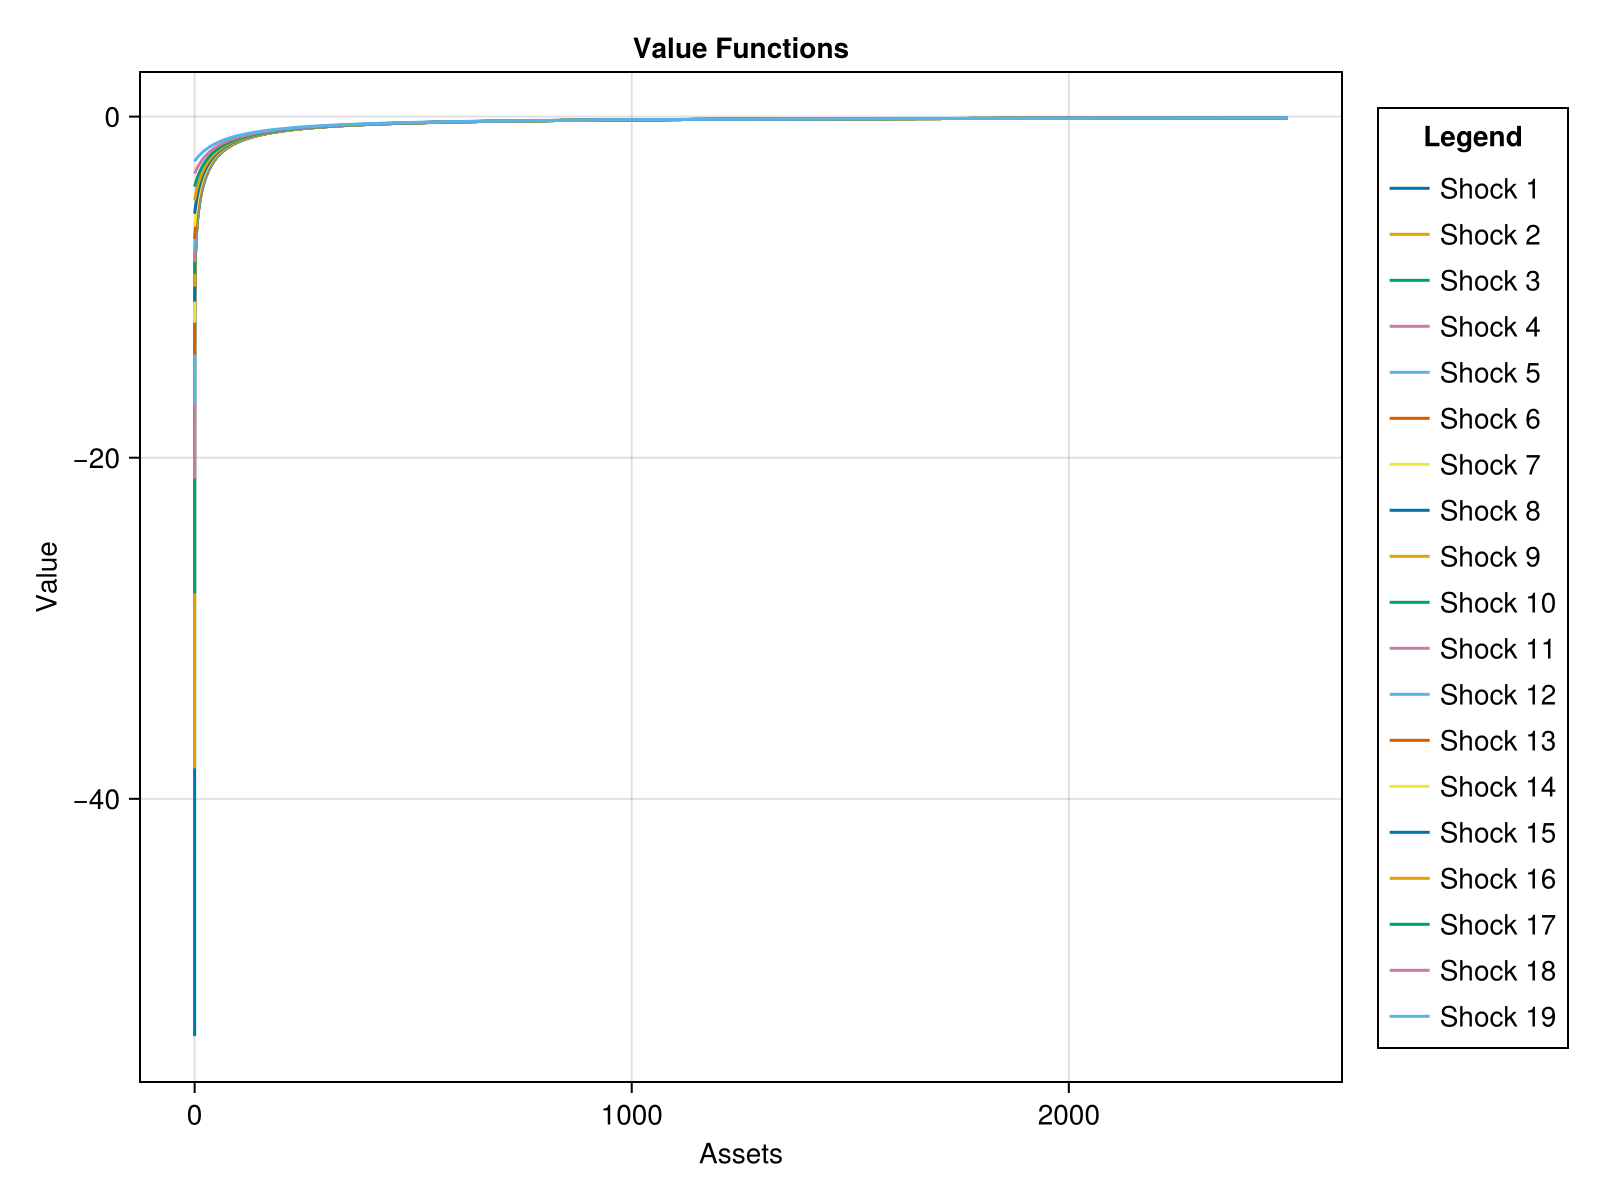

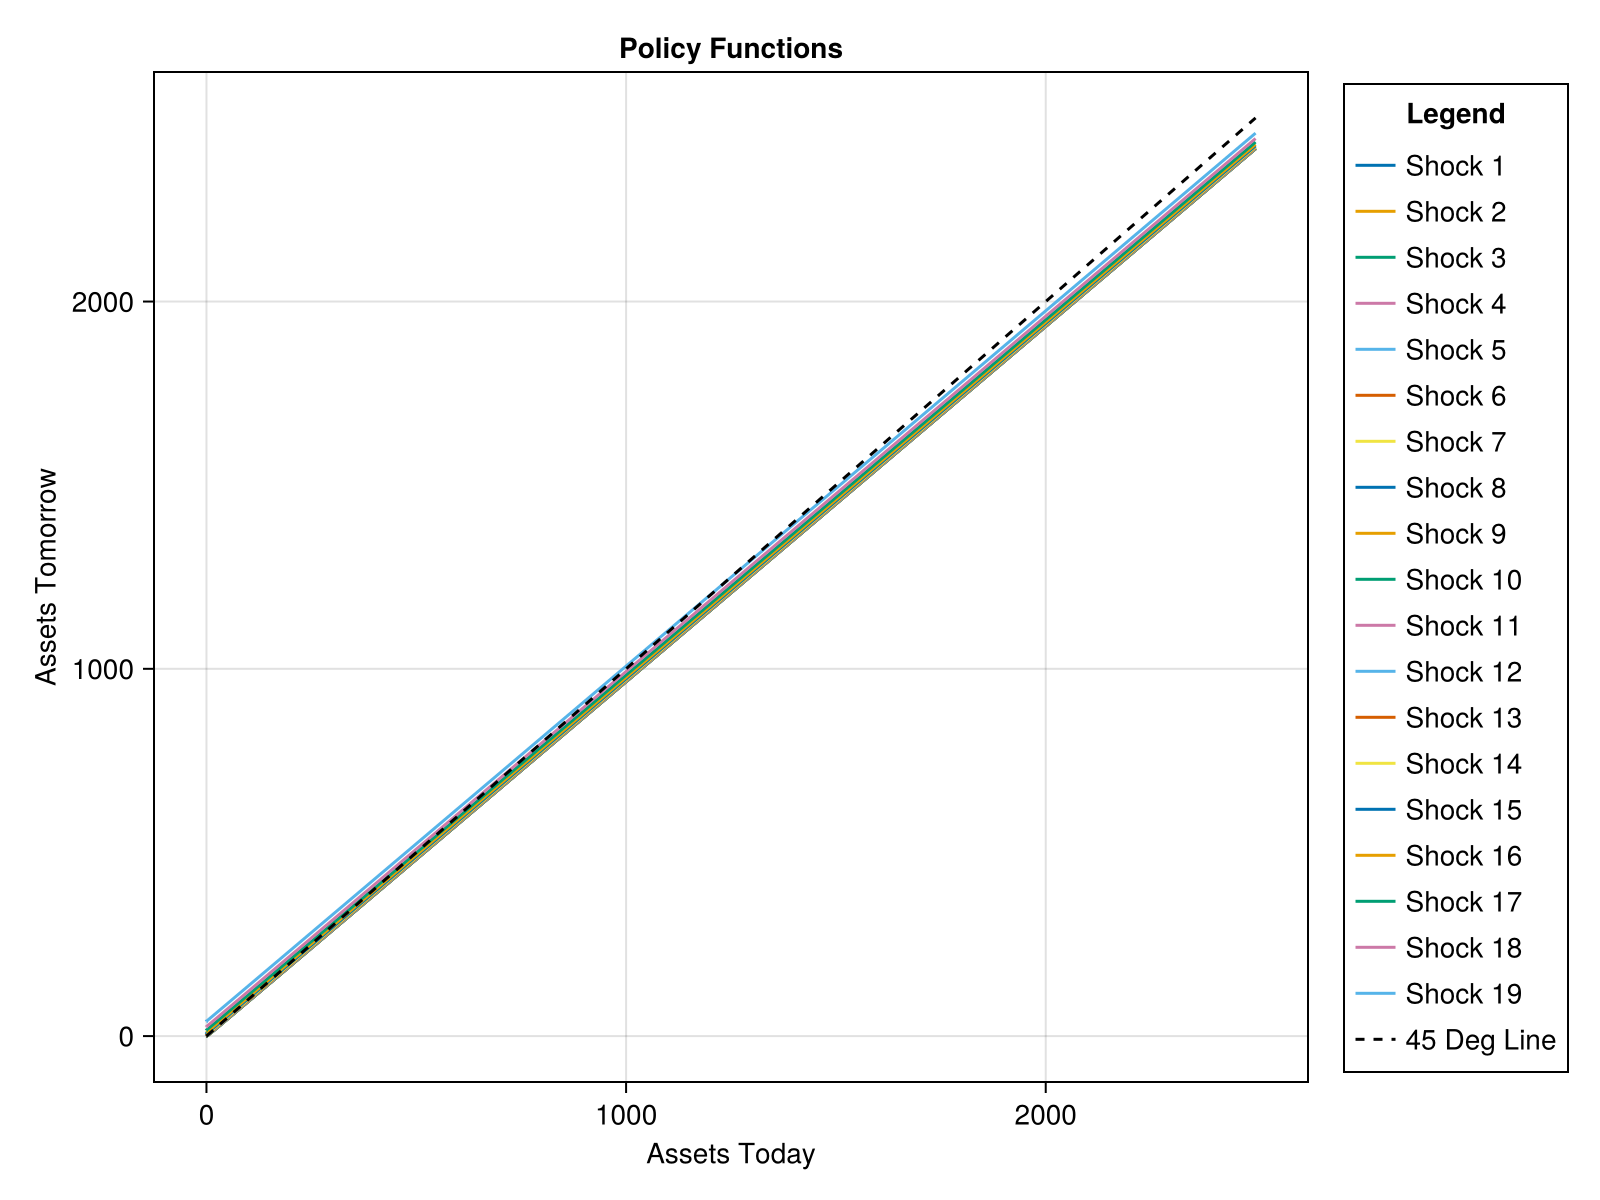

([-53.911290719319354 -38.216416879204324 … -3.3322209221951056 -2.6124874403102103; -53.8577782364307 -38.19350181584245 … -3.332219377546727 -2.612486526420802; … ; -0.0811074864690311 -0.0811071139299533 … -0.08016321946879124 -0.07967268356381962; -0.07795656342126935 -0.0779562193080231 … -0.07708395119454155 -0.07663030560890083], [2.4302926751808465e-16 4.403156486848758e-16 … 25.77498622995067 40.333193705418765; 2.4358004756772114e-16 4.406582749856711e-16 … 25.77501013653498 40.333217724375395; … ; 2320.795881920426 2320.8067122944526 … 2348.5681712309465 2363.254219386271; 2416.089721777405 2416.1005507832647 … 2443.8638998389447 2458.555412232215])

In [36]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 10 == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end

In [37]:
function utility_CES(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_CES(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-p.γ)
    return transformed_interp
end

function optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV_CES(Avals, expected_value, p)
        for j in 1:na
            obj_CES(ap) = - (((1-β) * utility_CES(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, j, i, p)  
            res = optimize(obj_CES, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

optimise_CES (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.8161556844308419
--------------------
Iteration: 10, Error: 0.31196395105436014
--------------------
Iteration: 20, Error: 0.8314037504245144
--------------------
Iteration: 30, Error: 1.9256109493335885
--------------------
Iteration: 40, Error: 3.252501858878375
--------------------
Iteration: 50, Error: 3.289675688950595
--------------------
Iteration: 60, Error: 1.9696898268885548
--------------------
Iteration: 70, Error: 0.8412417198949527
--------------------
Iteration: 80, Error: 0.3057459723493139
--------------------
Iteration: 90, Error: 0.10321336029440431
--------------------
Iteration: 100, Error: 0.0333330608818585
--------------------
Iteration: 110, Error: 0.01033869597685566
--------------------
Iteration: 120, Error: 0.0030633549832259632
--------------------
Iteration: 130, Error: 0.0008709752462436882
--------------------
Iteration: 140, Error: 0.00024949858672584924
--------------------
Iteration: 150, Error

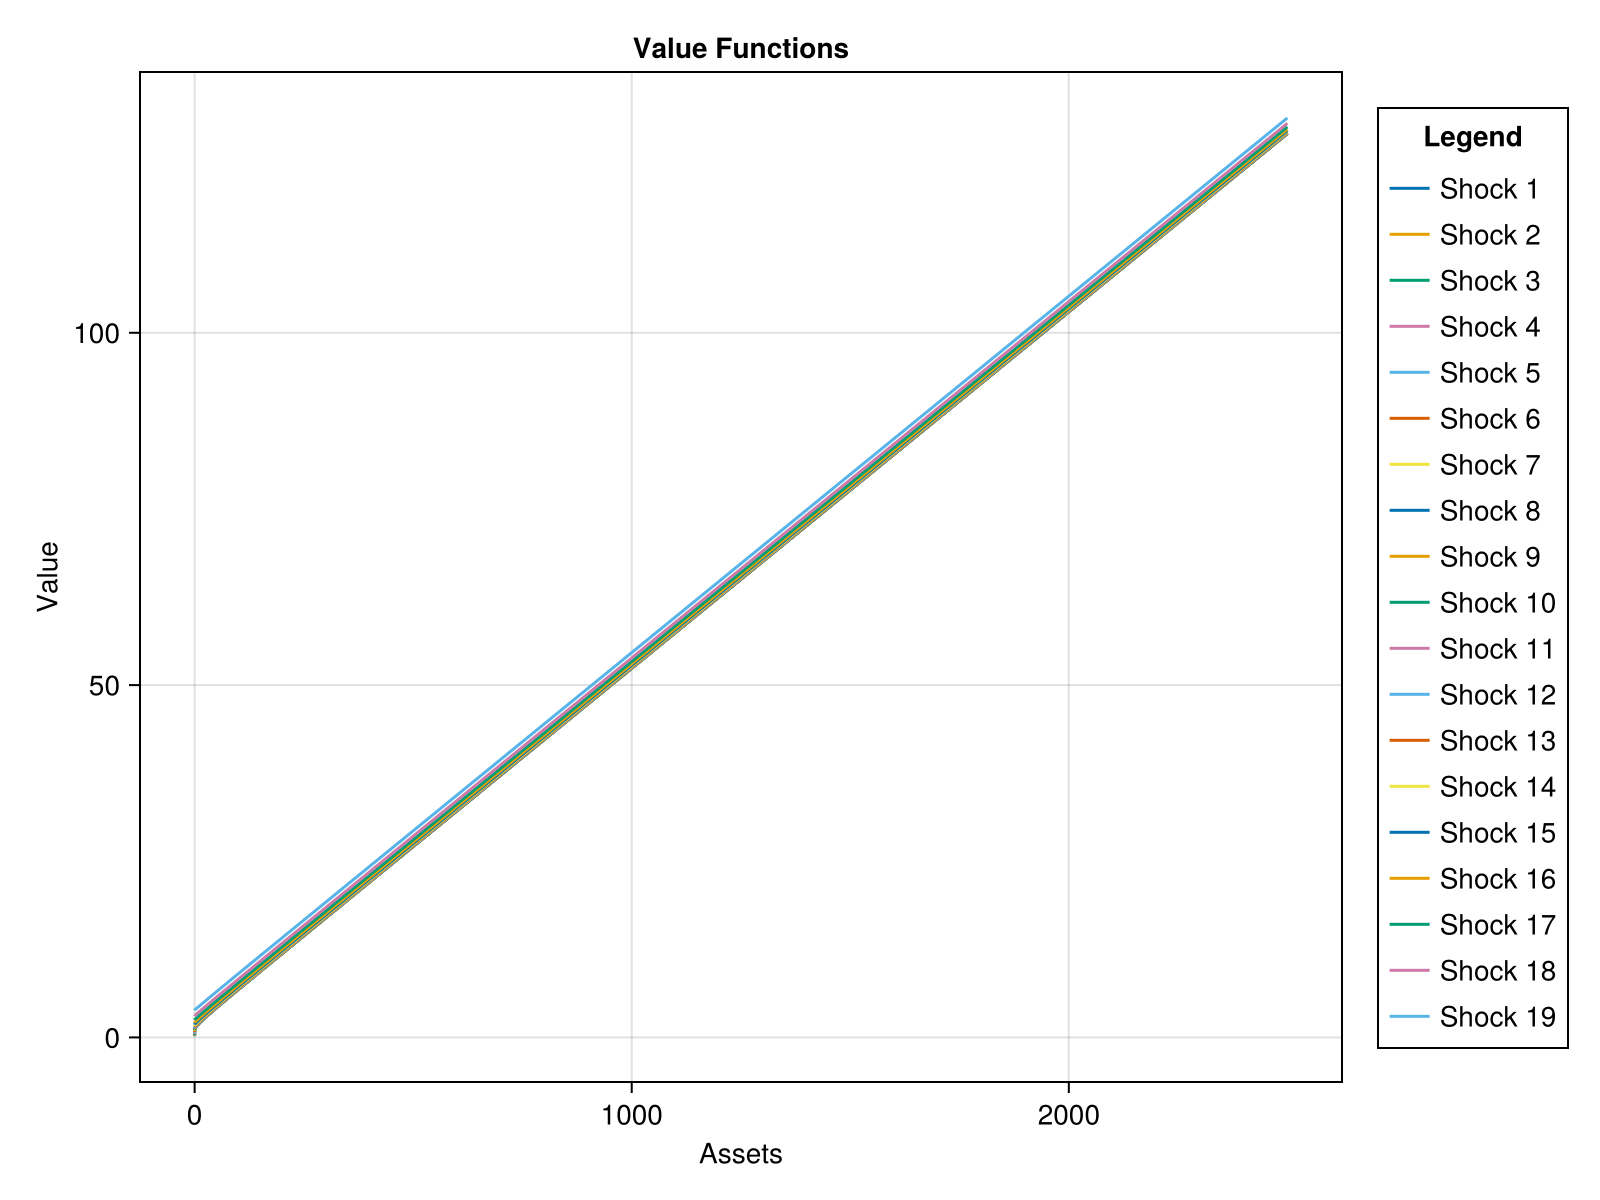

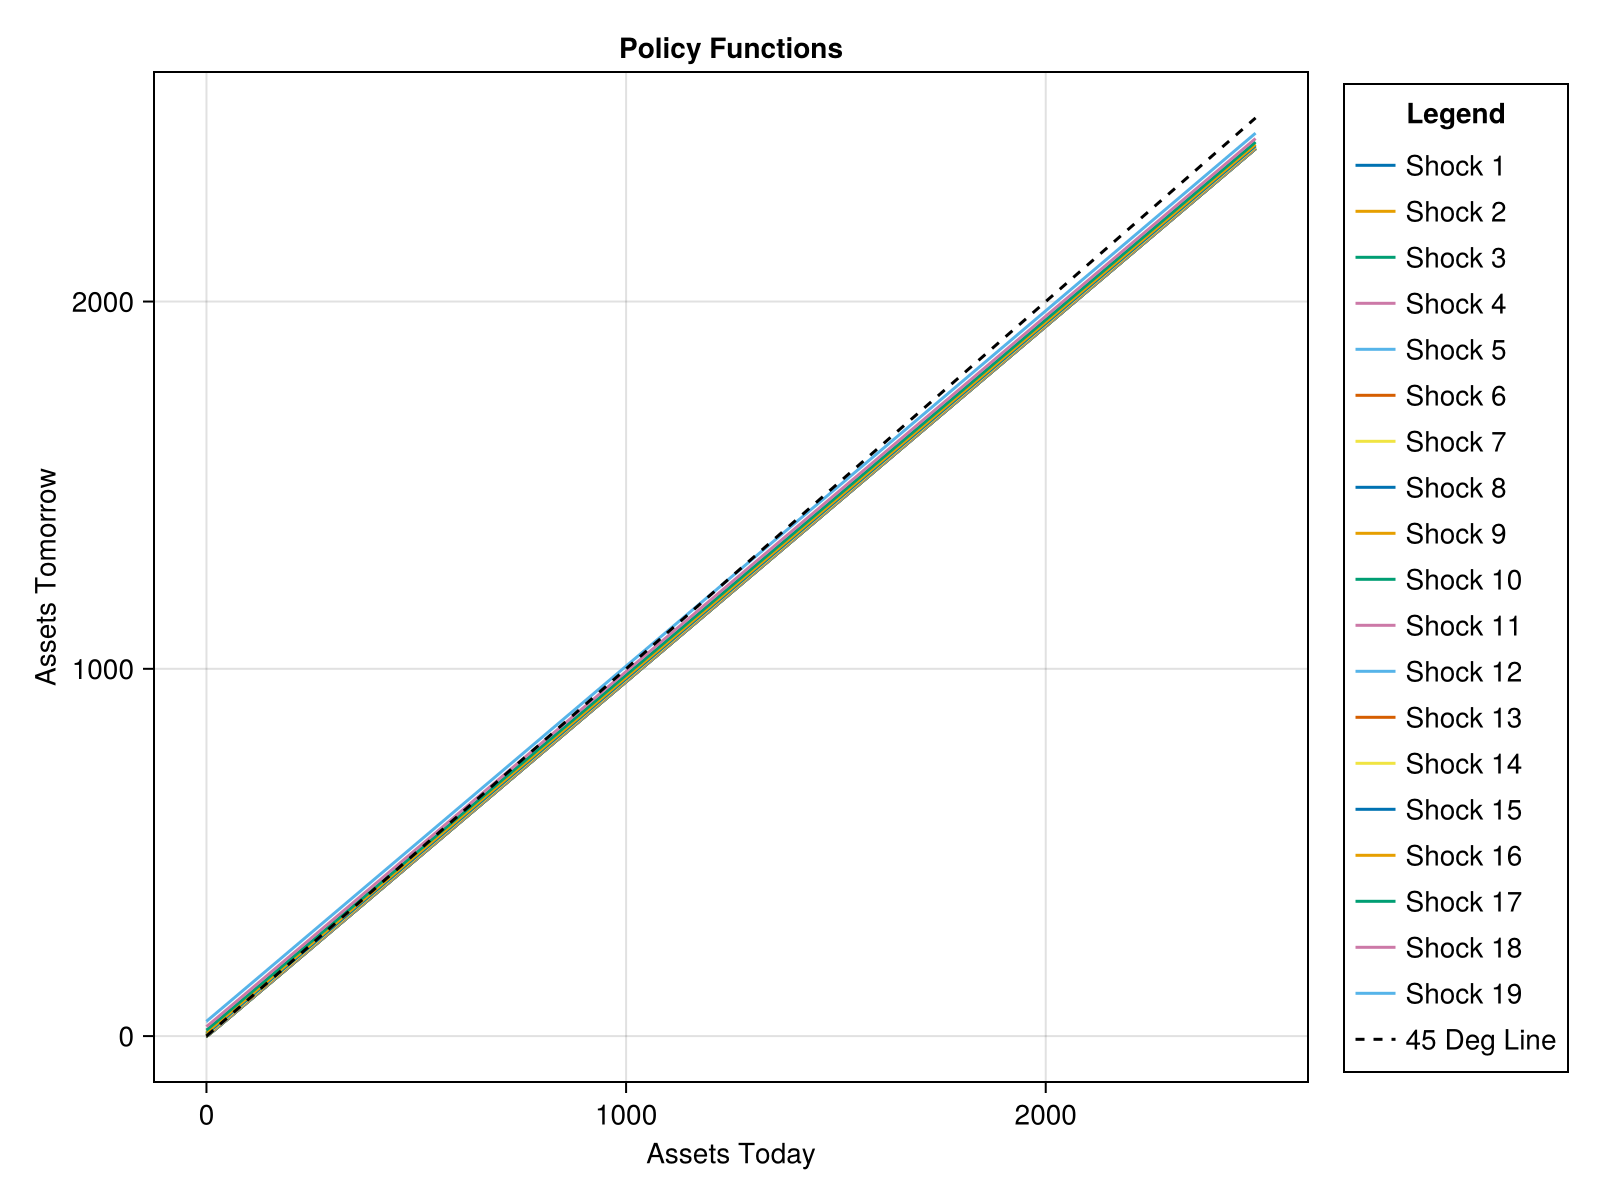

([0.18895841912429004 0.26862352032882075 … 3.073682764423636 3.891872447854953; 0.21209533832091076 0.2886667182718175 … 3.0738524755549763 3.8920362618434208; … ; 112.23876496082306 112.23933118667067 … 113.69086674358465 114.45881767919971; 128.27519394072118 128.27576016227877 … 129.72728498040138 130.49523044379254], [3.5181593885267114e-16 3.200489815799136e-16 … 25.650563084024473 40.21916098573518; 4.063431327780492e-16 3.6697090750085425e-16 … 25.653515658396007 40.22212851903143; … ; 2109.3690505211093 2109.3798803699888 … 2137.142507592252 2151.830642949751; 2416.089240912723 2416.1000707729095 … 2443.86272890854 2458.5508807508695])

In [38]:
function vfi_CES(v_init, p)
    (; maxiter, toler, nz, na) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init))
        v_init .= v_new
        if iter % 10 == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

p = (;r = 0.04, # interest rate
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 31, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    lb = 0.0, # lower bound of capital grid
    ub = 2500.0) # upper bound of capital grid

v2 = ones(p.na, p.nz)

@time begin
v_out, pol_out = vfi_CES(v2, p)
end